# 分类 Fashion-MNIST 数据集

现在轮到你来构建一个神经网络了。你将使用的是 [Fashion-MNIST 数据集](https://github.com/zalandoresearch/fashion-mnist)，这是 MNIST 数据集的替代品。对于神经网络而言，原始的 MNIST 数据集体量太小，因而你可以轻易达到 97% 以上的准确率。而 Fashion-MNIST 数据集是一组有关衣物的 28x28 灰阶图像。这个数据集比 MNIST 复杂得多，因此你能更好地判断神经网络的性能，它也更加接近你在现实世界中使用的数据集。

<img src='assets/fashion-mnist-sprite.png' width=500px>

在这个 notebook 中，你将构建专属于你的神经网络。在大多数情况下，你可以直接复制粘贴第三部分的代码，但这样一来你很难学到知识。因此我们推荐你自己编写代码来运行程序，这十分重要。不过在完成这个任务时，你也可以随时查阅和参考之前的 notebook。

首先，我们通过 torchvision 来加载数据集。

In [1]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

在这里，我们能看到其中一张图片。

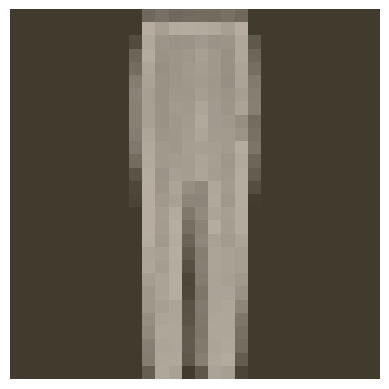

In [2]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

在加载数据之后，我们应该导入一些必要的包了。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

## 构建网络

在这里，你应该定义你的网络。如同 MNIST 数据集一样，这里的每张图片的像素为 28x28，共有 784 个像素点和 10 个类。你至少需要添加一个隐藏层。对于这些层，我们推荐你使用 ReLU 激活函数，并通过前向传播来返回 logits。层的数量和大小都由你来决定。

In [9]:
# TODO: Define your network architecture here
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc5 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        
        return x
    
    def predict(self, x):
        ''' This function for predicts classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

net = Network()
net

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)

# 训练网络

现在，你应该构建你的网络并训练它了。首先，你需要定义[条件](http://pytorch.org/docs/master/nn.html#loss-functions)（比如 `nn.CrossEntropyLoss`）以及[优化器](http://pytorch.org/docs/master/optim.html)（比如 `optim.SGD` 或 `optim.Adam`）。

接着，你需要编写训练代码。请记住，训练传播是一个十分简明的过程：

* 在网络中进行前向传播来获取 logits 
* 使用 logits 来计算损失
* 使用 `loss.backward()` 在网络中进行后向传播来计算梯度
* 使用优化器执行一个学习步来更新权重

通过调整超参数（隐藏单元、学习速率等），你应该可以将训练损失控制在 0.4 以下。

In [10]:
# TODO: Create the network, define the criterion and optimizer
net = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40

for e in range(epochs):
    for images, labels in trainloader:
        steps += 1
        # 将MNIST图像扁平化为784长度的向量
        images = images.view(images.size()[0], 784)
        
        # 将图像和标签包装在变量中，以便计算梯度
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # 测试准确率
            accuracy = 0
            with torch.no_grad():  # 禁用梯度计算
                for ii, (images, labels) in enumerate(testloader):
                    images = images.view(images.size()[0], 784)
                    inputs = Variable(images)

                    predicted = net.predict(inputs).data
                    equality = (labels == predicted.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0


Epoch: 1/2 Loss: 1.2951 Test accuracy: 0.6784
Epoch: 1/2 Loss: 0.7323 Test accuracy: 0.7319
Epoch: 1/2 Loss: 0.6467 Test accuracy: 0.7376
Epoch: 1/2 Loss: 0.5914 Test accuracy: 0.7730
Epoch: 1/2 Loss: 0.5458 Test accuracy: 0.8003
Epoch: 1/2 Loss: 0.5039 Test accuracy: 0.7982
Epoch: 1/2 Loss: 0.5355 Test accuracy: 0.8076
Epoch: 1/2 Loss: 0.5080 Test accuracy: 0.8174
Epoch: 1/2 Loss: 0.5285 Test accuracy: 0.8121
Epoch: 1/2 Loss: 0.5018 Test accuracy: 0.8189
Epoch: 1/2 Loss: 0.4887 Test accuracy: 0.8231
Epoch: 1/2 Loss: 0.4986 Test accuracy: 0.8215
Epoch: 1/2 Loss: 0.4644 Test accuracy: 0.8236
Epoch: 1/2 Loss: 0.4574 Test accuracy: 0.8330
Epoch: 1/2 Loss: 0.4449 Test accuracy: 0.8180
Epoch: 1/2 Loss: 0.4426 Test accuracy: 0.8149
Epoch: 1/2 Loss: 0.4712 Test accuracy: 0.8269
Epoch: 1/2 Loss: 0.4379 Test accuracy: 0.8435
Epoch: 1/2 Loss: 0.4333 Test accuracy: 0.8404
Epoch: 1/2 Loss: 0.4212 Test accuracy: 0.8372
Epoch: 1/2 Loss: 0.4238 Test accuracy: 0.8367
Epoch: 1/2 Loss: 0.4437 Test accur

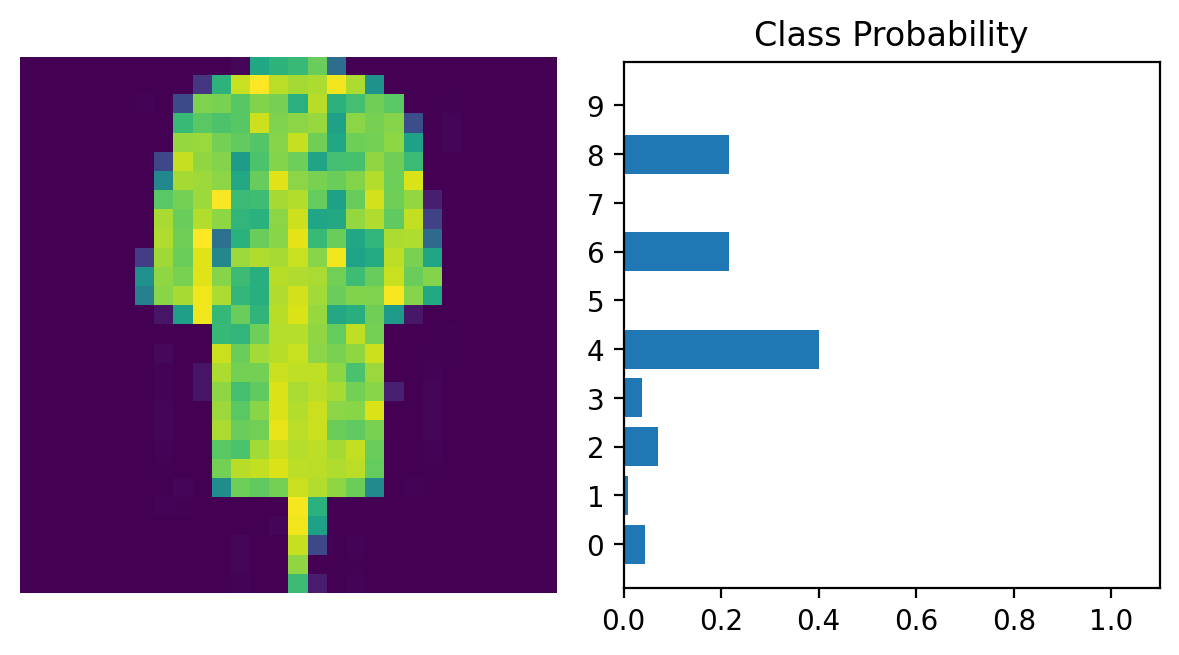

In [13]:
# Test out your network!

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
ps = net.predict(Variable(img.resize_(1, 784)))

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps)

训练好神经网络之后，你应该希望保存这个网络以便下次加载，而不是重新训练。很明显，每次使用时都重新训练网络并不现实。在实际操作中，你将会在训练网络之后将模型保存，接着重新加载网络以进行训练或是预测。在下一部分，我将为你展示如何保存和加载训练好的模型。